# ImageFolder

## 데이터 준비

In [ ]:
from google.colab import drive
import os
import shutil
import zipfile

# 데이터 준비

# 지정 위치와 구글 드라이브 연결
drive.mount("/content/gdrive/")

ROOT_DIR = "/content"
DATA_ROOT_DIR = "/content/data"

# zip파일 복사 #
shutil.copy(os.path.join("/content/gdrive/MyDrive/SAI_STUDY/data", "custom_data.zip"), ROOT_DIR)

# zip파일 압축 풀기 #
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "custom_data.zip")) as target_file:
    target_file.extractall(ROOT_DIR)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline

In [ ]:
# 이미지 사이즈 재조정
trans = transforms.Compose([
    transforms.Resize((64, 128))
])

train_data = torchvision.datasets.ImageFolder(root="custom_data/origin_data", transform=trans)

In [ ]:
for num, value in enumerate(train_data):
    data, label = value
    print(num, data, value)

    if label == 0:
        data.save(f'custom_data/train_data/gray/{num}_{label}.jpeg')
    else:
        data.save(f'custom_data/train_data/red/{num}_{label}.jpeg')

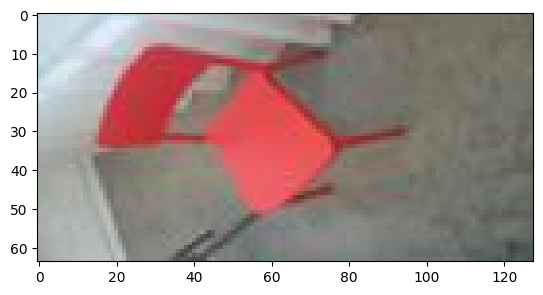

In [ ]:
data, _ = train_data[500]
imshow(data)

## 모델 학습 및 저장

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cpu


In [ ]:
# 이미지 사이즈 재조정
trans = transforms.Compose([
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root="custom_data/train_data", transform=trans)

In [ ]:
data_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
# model 생성
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__() # 꼭 해줘야 학습이 된다고..!!!!
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(16*13*29, 120),
            nn.ReLU(),
            nn.Linear(120, 2)
        )

    def forward(self, x):
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = out.view(out.shape[0], -1)
        # print(out.shape)
        out = self.layer3(out)
        return out

In [ ]:
# Test
net = CNN().to(device)
test_input = (torch.Tensor(3, 3, 64, 128)).to(device)
test_out = net(test_input)
test_out

tensor([[nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.00001)
loss_func = nn.CrossEntropyLoss().to(device)

In [ ]:
# training
total_batch = len(data_loader)

epoch = 5
for epoch in range(epoch):
    avg_cost = 0

    for num, data in enumerate(data_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # 필수!!!
        out = net(imgs)
        loss = loss_func(out, labels)
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch

    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))

print('Finished~~~~!')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bce63a03f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bce63a03f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[Epoch:1] cost = 0.676770031452179
[Epoch:2] cost = 0.618465006351471
[Epoch:3] cost = 0.5386515855789185
[Epoch:4] cost = 0.4421849846839905
[Epoch:5] cost = 0.3521715998649597
Finished~~~~!


In [ ]:
# 학습시킨 모델 저장
torch.save(net.state_dict(), '/content/model.pth')

In [ ]:
# 저장해둔 모델 불러오기
new_net = CNN().to(device) # 이렇게 사전준비 해줘야 함
new_net.load_state_dict(torch.load('/content/model.pth'))

<All keys matched successfully>

In [ ]:
# TEST용 이미지 사이즈 재조정
trans = transforms.Compose([
    transforms.Resize((64, 128)),
    transforms.ToTensor()
])

test_data = torchvision.datasets.ImageFolder(root="custom_data/test_data", transform=trans)

In [ ]:
test_set = DataLoader(dataset=test_data, batch_size=len(test_data))

In [ ]:
# Test
with torch.no_grad(): # 학습 시키는 데이터가 아니라고 명시해 주는 것
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)

        prediction = net(imgs)
        correct_prediction = torch.argmax(prediction, 1) == label
        accuracy = correct_prediction.float().mean()
        print('Accuracy :', accuracy.item())

Accuracy : 1.0


# Advance CNN(VGG)

- 모델 커스텀하기

In [ ]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [ ]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()

        self.features = features #convolution

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) # 1열로 펼치기
        x = self.classifier(x) # FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [ ]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}

In [ ]:
conv = make_layers(cfg['custom'], batch_norm=True)

In [ ]:
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
CNN = VGG(make_layers(cfg['custom']), num_classes=10, init_weights=True)

In [ ]:
CNN

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin